# Домашнее задание №4
Вариант: Мультимодальные данные

In [1]:
import os
from io import BytesIO
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModel

import requests
from tqdm import tqdm

import torch

В предыдущих практических заданиях был сформирован набор данных, который уже имеет задатки "мультимодальности" и содержит:
- текстовые описания квартир;
- ссылки на изображения квартир (часть из которых была размечена в предыдущей работе);
- геоданные (координаты);
- набор числовых и категориальных признаков.

В данном задании принято решение продолжить работу над этим же датасетом: нормализовать его мультимодальные признаки и сформировать концепцию строения мультимодального набора данных.

## 1 Загрузка главных изображений из объявлений об аренде

Загрузим главные фото объявлений из датасета с квартирами:

In [2]:
IMAGE_FOLDER = 'D:/real_estate_images'

# # Создаем папку, если ее нет
# os.makedirs(IMAGE_FOLDER, exist_ok=True)

# def download_image(url, save_path):
#     """Функция для скачивания и сохранения изображения"""
#     try:
#         response = requests.get(url, timeout=15)
#         response.raise_for_status()  # Проверяем на ошибки HTTP
        
#         # Проверяем, что это действительно изображение
#         if 'image' not in response.headers.get('content-type', ''):
#             raise ValueError("URL не ведет к изображению")
            
#         img = Image.open(BytesIO(response.content))
        
#         # Конвертируем в RGB если нужно
#         if img.mode != 'RGB':
#             img = img.convert('RGB')
            
#         img.save(save_path)
#         return True
        
#     except Exception as e:
#         print(f"\nОшибка при загрузке {url}: {str(e)}")
#         return False

In [3]:
# Загружаем данные
df = pd.read_csv('C:/Users/popov/mirkvartir_with_labels.csv', sep=';')

In [4]:
# success_count = 0
# failed_urls = []

# for idx, row in tqdm(df.iterrows(), total=len(df), desc="Скачивание изображений"):
#     url = row['main_photo_url']
    
#     filename = f"{row['id']}_{url.split('/')[-1]}"
#     save_path = os.path.join(IMAGE_FOLDER, filename)
    
#     if os.path.exists(save_path):
#         success_count += 1
#         continue
        
#     if download_image(url, save_path):
#         success_count += 1
#     else:
#         failed_urls.append(url)

# print(f"\nУспешно скачано: {success_count}/{len(df)}")
# print(f"Не удалось скачать: {len(failed_urls)}")

# # Сохраняем список неудачных
# if failed_urls:
#     with open(os.path.join(IMAGE_FOLDER, 'failed_downloads.txt'), 'w') as f:
#         f.write('\n'.join(failed_urls))

Не удалось загрузить всего 8 фотографий из 4702. Удалим строки с недостающими фотографиями:

In [5]:
urls_to_remove = [
    'https://f1.mirkvartir.me/custom/ea/ea00d6e6-f375-4d1d-8d56-de8c50f7a797.jpg',
    'https://f1.mirkvartir.me/custom/b9/b9d12c7c-1d59-4f86-a7f0-c65447fe1016.jpg',
    'https://f5.mirkvartir.me/custom/b6/b681a2fe-4cc0-47bc-856e-7d2691f8cd9b.jpg',
    'https://f3.mirkvartir.me/custom/07/074cbfcd-7d1e-4c91-8d8f-1f754e3daf78.jpg',
    'https://f1.mirkvartir.me/custom/48/487a54c5-3adb-458c-b776-b93ccede4559.jpg',
    'https://f7.mirkvartir.me/custom/4b/4b10e12a-aea9-4ae3-92d0-89b2f53ade3b.jpg',
    'https://f5.mirkvartir.me/custom/df/dfe37b41-d36e-451c-891f-9ebb0009f787.jpg',
    'https://f6.mirkvartir.me/custom/e2/e2ac17c5-1ec0-4c9c-933a-4fe0833297e2.jpg'
]

Проверим, удалилось ли корректное число строк:

In [6]:
original_count = len(df)

df = df[~df['main_photo_url'].isin(urls_to_remove)]

removed_count = original_count - len(df)
print(f'Удалено строк: {removed_count}')
print(f'Осталось строк: {len(df)}')

Удалено строк: 8
Осталось строк: 4694


Все верно!

## 2 Мультимодальные признаки

Составим списки признаков по категориям:

In [7]:
numerical_features = ['price', 'rooms', 'area', 'floor', 
                     'total_floors', 'price_per_sqm', 'dist_to_metro', 'dist_to_park', 
                     'dist_to_water', 'dist_to_airport']
text_features = ['title', 'description', 'address']
categorical_features = ['metro_name', 'agency_name', 'source']
geo_features = ['latitude', 'longitude']

### Текстовые признаки

Посмотрим на размерность текстовых признаков:

In [8]:
print("Анализ текстовых признаков:")
for feature in text_features:
    print(f"\n{feature.upper()}:")
    print(f"Средняя длина: {df[feature].str.len().mean():.2f} символов")
    print(f"Максимальная длина: {df[feature].str.len().max()} символов")

Анализ текстовых признаков:

TITLE:
Средняя длина: 24.86 символов
Максимальная длина: 29 символов

DESCRIPTION:
Средняя длина: 283.91 символов
Максимальная длина: 366 символов

ADDRESS:
Средняя длина: 41.43 символов
Максимальная длина: 89 символов


Самый короткий текстовый признак - `title`. Это вызвано строгим форматом данного признака в агрегаторе Мирквартир.

Самый значительный по длине признак `description`, что также логично - описание содержит подробную информацию о квартире и иногда о ее окрестностях.

Посмотрим на облако слов по столбцу `description`.

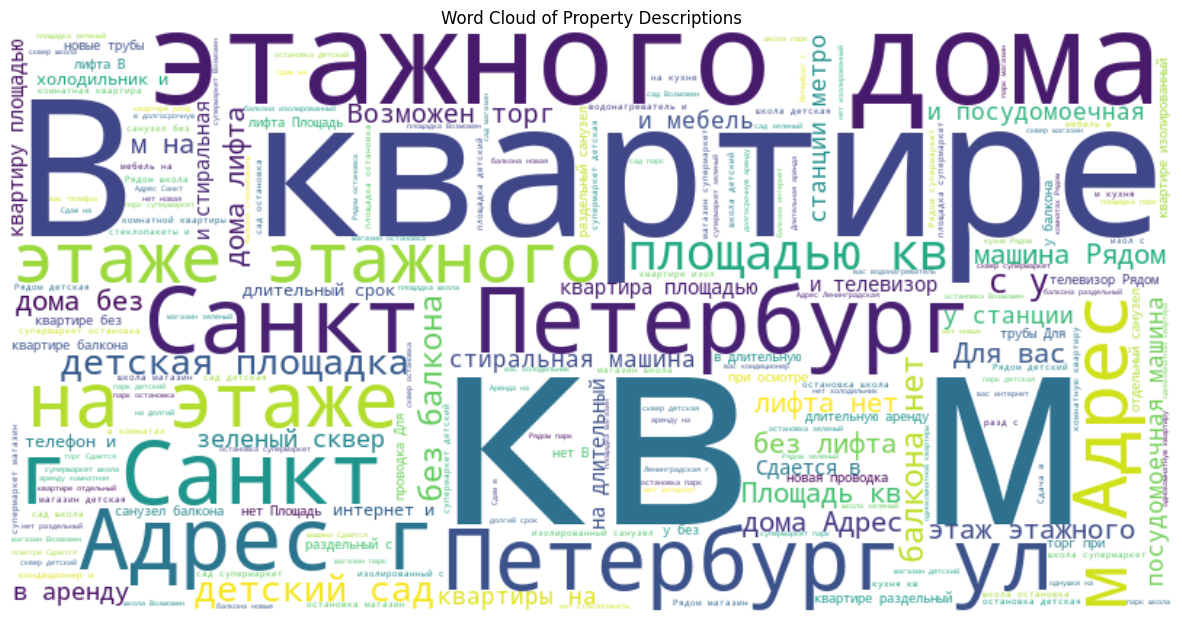

In [9]:
text = ' '.join(df['description'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Property Descriptions')
plt.show()

В облаке слов наиболее крупные слова встречаются чаще всего - и побеждают... `В квартире`, `кв м` и `этажного дома`.

### Изображения

Посмотрим на пример главных фото квартир:

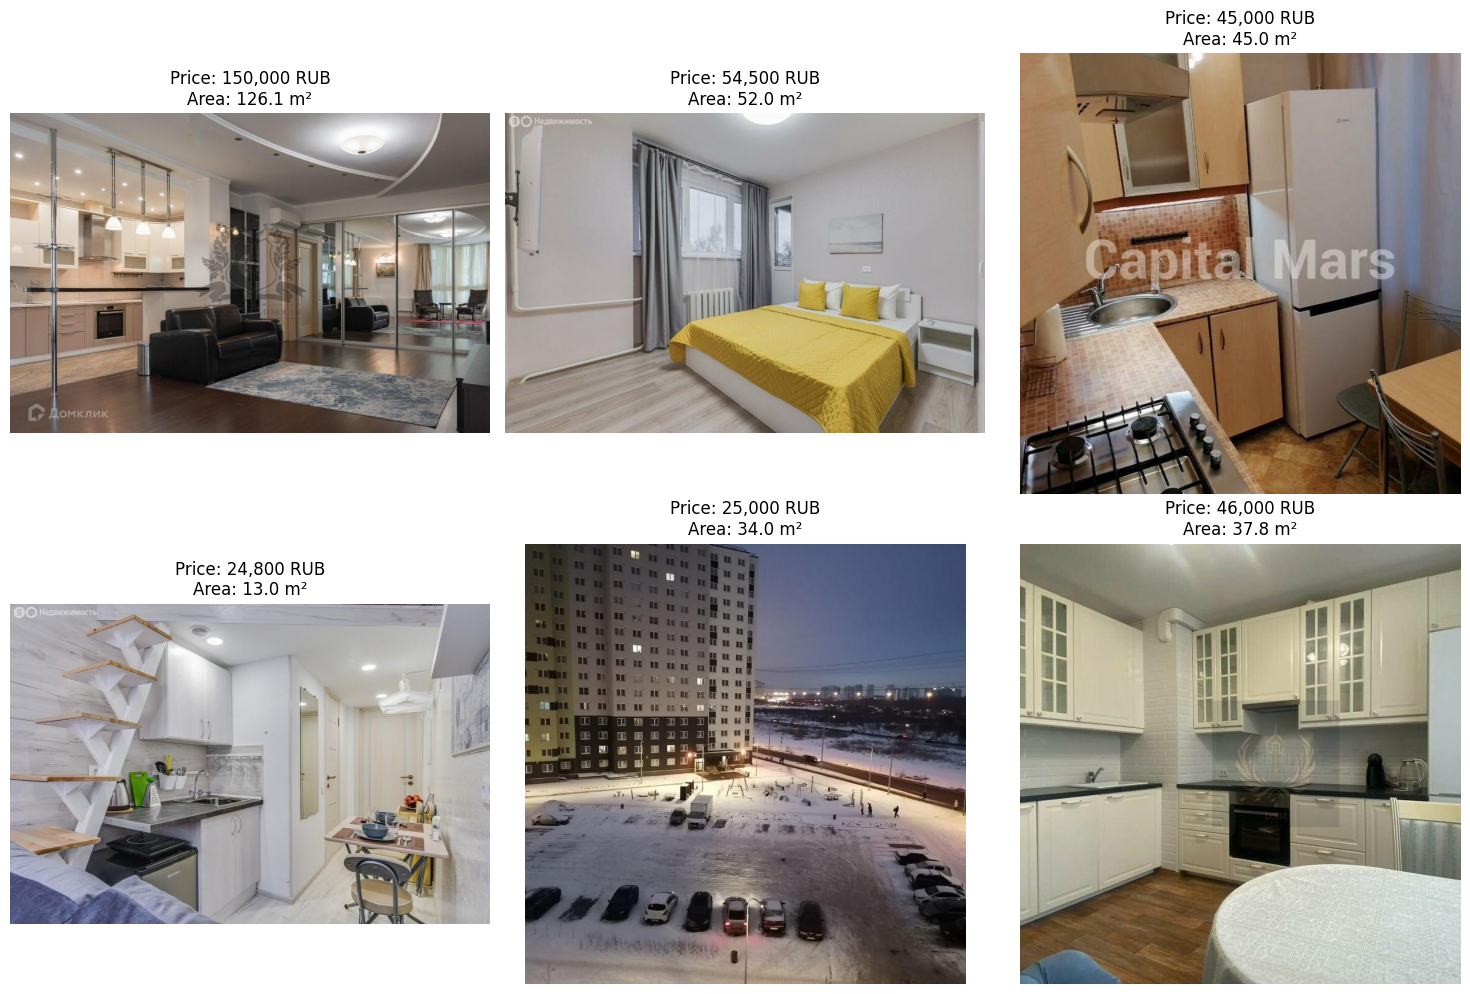

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sample_images = df.sample(6)
for idx, (i, row) in enumerate(sample_images.iterrows()):
    img_path = f"{IMAGE_FOLDER}/{row['main_photo_name']}"
    try:
        img = load_img(img_path)
        ax = axes[idx//3, idx%3]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Price: {row['price']:,} RUB\nArea: {row['area']} m²")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.show()

Несложно заметить, что квартиры с хорошим ремонтом из этой небольшой выборки - выше в цене. Так, фото интерьеров позволяют делать выводы о значимом признаке - качестве ремонта (частичная ручная разметка этого признака была осуществлена в ДЗ №3).

## 3 Нормализация изображений

Произведем подготовку загруженных изображений - приведем к единой размерности и нормализуем их:

In [11]:
PROCESSED_IMAGES_DIR = 'D:/processed_images'
if not os.path.exists(PROCESSED_IMAGES_DIR):
    os.makedirs(PROCESSED_IMAGES_DIR)

def preprocess_and_save_images(df, source_folder, target_folder, target_size=(224, 224)):
    """
    Предобработка и сохранение изображений
    """
    processed_images = []
    
    print("Processing images...")
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(source_folder, row['main_photo_name'])
        
        try:
        
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            
      
            img_array = img_array / 255.0
            
            # Сохраняем обработанное изображение в numpy формате
            save_path = os.path.join(target_folder, f"{Path(row['main_photo_name']).stem}.npy")
            np.save(save_path, img_array)
            
            processed_images.append(save_path)
            
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            processed_images.append(None)
    
    return processed_images

In [12]:
processed_image_paths = preprocess_and_save_images(
    df, 
    IMAGE_FOLDER, 
    PROCESSED_IMAGES_DIR
)

Processing images...


100%|██████████| 4694/4694 [00:28<00:00, 166.26it/s]


Добавим путь к изображениям в датафрейм:

In [13]:
df['processed_image_path'] = processed_image_paths

## 4 Векторизация описаний

Загрузим BERT для векторизации текста:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model = AutoModel.from_pretrained('bert-base-multilingual-cased')

def get_text_embeddings(text, max_length=512):
    # Подготовка текста
    inputs = tokenizer(text, return_tensors="pt", max_length=max_length, 
                      truncation=True, padding=True)
    
    # Получение эмбеддингов
    with torch.no_grad():
        outputs = model(**inputs)
    
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings[0]

Сформируем эмбеддинги:

In [15]:
description_embeddings = []
for desc in tqdm(df['description']):
    embedding = get_text_embeddings(desc)
    description_embeddings.append(embedding)

100%|██████████| 4694/4694 [16:46<00:00,  4.66it/s]


Преобразуем эмбеддинги в numpy-массив и сохраним:

In [16]:
description_embeddings = np.array(description_embeddings)

np.save('D:/description_embeddings.npy', description_embeddings)

Сохраним данные:

In [ ]:
# df.to_csv('processed_dataset.csv', index=False)

## 5 Структура мультимодального датасета

```plaintext
1. ТАБЛИЧНЫЕ ДАННЫЕ (DataFrame)
   └── id (Primary Key)
       ├── Числовые признаки
       │   ├── price
       │   ├── area
       │   ├── rooms
       │   └── ...
       ├── Категориальные признаки
       │   ├── metro_name
       │   ├── agency_name
       │   └── source
       └── Связующие поля
           ├── main_photo_name (-> исходные изображения)
           ├── processed_image_path (-> нормализованные изображения)
           └── description (-> связь с текстовыми эмбеддингами)

2. ОБРАБОТАННЫЕ ИЗОБРАЖЕНИЯ (Директория: processed_images)
   └── numpy arrays (.npy файлы)
       ├── img_1.npy
       ├── img_2.npy
       └── ...
       └── Характеристики:
           ├── Размер: (224, 224, 3)
           ├── Тип данных: float32
           ├── Диапазон значений: [0, 1]
           └── Нормализация: выполнена

3. ТЕКСТОВЫЕ ЭМБЕДДИНГИ (NumPy array: description_embeddings.npy)
   └── shape: (4702, 768)
       ├── row_0: [...]
       ├── row_1: [...]
       └── ...

ПРИНЦИП СВЯЗКИ:
==============

id_1 ─┬── DataFrame[id_1] ──────┬── Числовые признаки
      ├── processed_images/img_1.npy
      └── description_embeddings[0]

id_2 ─┬── DataFrame[id_2] ──────┬── Числовые признаки
      ├── processed_images/img_2.npy
      └── description_embeddings[1]


ФОРМАТ ДАННЫХ ДЛЯ МОДЕЛИ:
========================

class RealEstateDataset:
    def __init__(self, df, processed_images_dir, description_embeddings):
        self.df = df
        self.processed_images_dir = processed_images_dir
        self.description_embeddings = description_embeddings
    
    def __getitem__(self, idx):
        # Загрузка обработанного изображения
        img = np.load(self.df.iloc[idx]['processed_image_path'])
        
        # Получение текстового эмбеддинга
        text_embedding = self.description_embeddings[idx]
        
        # Получение табличных признаков
        tabular = self.df.iloc[idx][numerical_features + categorical_features].values
        
        return {
            'tabular': tabular,
            'image': img,
            'text_embedding': text_embedding,
            'target': self.df.iloc[idx]['price']  # или другая целевая переменная
        }
```

**Преимущества подхода:**

- Изображения предварительно обработаны и нормализованы
- Хранение в .npy формате ускоряет загрузку
- Все модальности оптимизированы для быстрой загрузки в память
- Структура данных готова для использования с PyTorch DataLoader или tf.data.Dataset

## Потенциальное применение

**Варианты использования:**
- А. Модель оценки стоимости недвижимости:

    - Использование всех типов данных для более точной оценки стоимости
    - Изображения помогут оценить состояние и качество ремонта
    - Текстовые описания могут содержать важные детали о преимуществах объекта
    - Числовые параметры предоставляют объективные характеристики
- Б. Система рекомендаций недвижимости:

    - Поиск похожих объектов по всем модальностям
    - Ранжирование результатов по релевантности
    - Персонализированные рекомендации на основе предпочтений пользователя
- В. Автоматическая категоризация объектов недвижимости:

    - Классификация типа недвижимости
    - Оценка состояния ремонта по фотографиям
    - Выявление особенностей планировки
    - Определение стиля интерьера

**Потенциальная архитектура модели:**

Для создания эффективной мультимодальной модели можно использовать архитектуру с тремя входными ветвями:

1. Изображения:
    - Использование предобученной сверточной сети
    - Извлечение визуальных признаков

2. Текст:
    - Использование предобученной языковой модели
    - Извлечение семантических признаков

3. Табличные данные:
    - Нормализация числовых признаков
    - Кодирование категориальных признаков
    - Полносвязные слои для обработки

Затем признаки от всех трёх ветвей объединяются и подаются на финальные слои для получения предсказания (например, цены или категории объекта).

## Defenition of Done

Собрать и разметить мультимодальные данные (например, текст, звук, изображения) и разработать стратегию их интеграции для решения задачи машинного обучения.

- ✅  Соберите/доберите или найдите готовый датасет, чтобы дополнить ваш проект до мультимодальности
- ✅  Разметьте мультимодальные данные и сделайте связку данных, если она еще не сделана (т.е сформируйте мультимодальный датасет)
- ✅  Опишите принцип связки мультимодельных данных
- ✅  Проведите предварительную обработку данных (например, очистка текста, нормализация изображений).
- ✅  Сделайте EDA для этих данных
- ✅  Опишите возможные кейсы использования полученных мультимодальных данных. (где их можно использовать/какую модель построить и тд)